importing necessary library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.models import Model, Sequential
import pickle

Pre-Processing & Exploratory data analysis

In [4]:
# Load dataset
df = pd.read_csv(r"C:\Users\Abhishek\Desktop\New folder\ner_dataset.csv", encoding="latin1")

In [7]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [8]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [9]:
# Fill missing sentence numbers (forward fill)
df["Sentence #"] = df["Sentence #"].fillna(method="ffill")


In [10]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [11]:
# Unique words and tags
unique_words = df["Word"].nunique()
unique_tags = df["Tag"].nunique()

# Count of each tag
tag_counts = df["Tag"].value_counts()

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_12360\2166483771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="viridis")


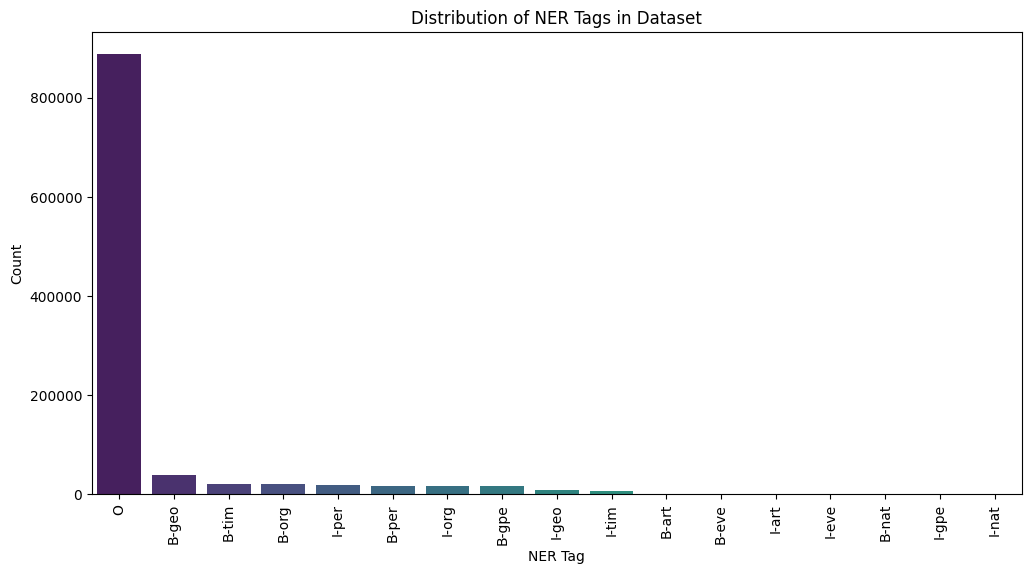

In [12]:
# Plot tag distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("NER Tag")
plt.ylabel("Count")
plt.title("Distribution of NER Tags in Dataset")
plt.show()

In [13]:
# Compute sentence lengths
sentence_lengths = df.groupby("Sentence #")["Word"].count()


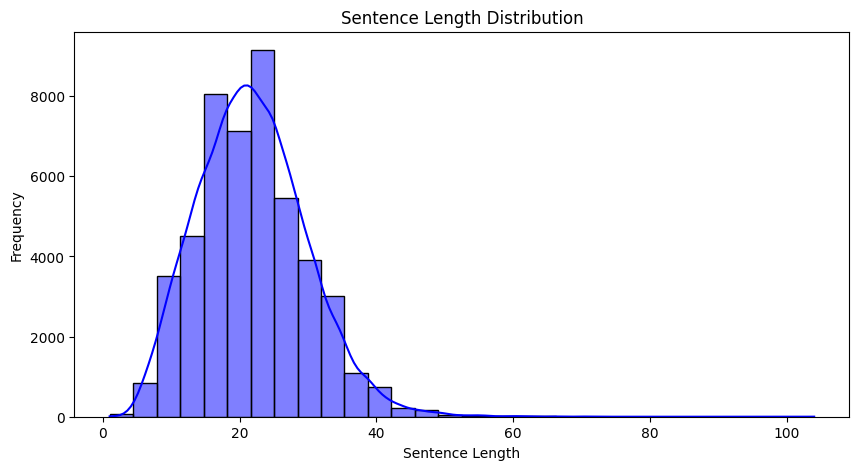

In [14]:
# Plot sentence length distribution
plt.figure(figsize=(10, 5))
sns.histplot(sentence_lengths, bins=30, kde=True, color="blue")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.show()

In [15]:
# Split dataset into Train (70%), Validation (10%), and Test (20%)
unique_sentences = df["Sentence #"].unique()
train_sent, test_sent = train_test_split(unique_sentences, test_size=0.20, random_state=42)
train_sent, val_sent = train_test_split(train_sent, test_size=0.125, random_state=42)  # 0.125 * 0.80 = 10%

train_data = df[df["Sentence #"].isin(train_sent)]
val_data = df[df["Sentence #"].isin(val_sent)]
test_data = df[df["Sentence #"].isin(test_sent)]

# Print dataset sizes
print(f"Train Data: {len(train_data)} rows")
print(f"Validation Data: {len(val_data)} rows")
print(f"Test Data: {len(test_data)} rows")


Train Data: 734306 rows
Validation Data: 105334 rows
Test Data: 208935 rows


In [16]:
# Prepare data for model training
words = list(set(df["Word"].values))
tags = list(set(df["Tag"].values))
n_words = len(words)
n_tags = len(tags)
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

In [17]:
# Convert sentences into sequences
max_len = max(sentence_lengths)
x_train = [[word2idx[w] for w in train_data[train_data["Sentence #"] == s]["Word"]] for s in train_sent]
y_train = [[tag2idx[t] for t in train_data[train_data["Sentence #"] == s]["Tag"]] for s in train_sent]

x_val = [[word2idx[w] for w in val_data[val_data["Sentence #"] == s]["Word"]] for s in val_sent]
y_val = [[tag2idx[t] for t in val_data[val_data["Sentence #"] == s]["Tag"]] for s in val_sent]

x_test = [[word2idx[w] for w in test_data[test_data["Sentence #"] == s]["Word"]] for s in test_sent]
y_test = [[tag2idx[t] for t in test_data[test_data["Sentence #"] == s]["Tag"]] for s in test_sent]

# Padding sequences
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_len, padding='post')
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

x_val = pad_sequences(x_val, maxlen=max_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len, padding='post')
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]

x_test = pad_sequences(x_test, maxlen=max_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len, padding='post')
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]


In [19]:
# Define LSTM model
model = Sequential([
    Embedding(input_dim=n_words + 1, output_dim=50, input_length=max_len),
    Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)),
    TimeDistributed(Dense(n_tags, activation="softmax"))
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 104, 50)           1758950   
                                                                 
 bidirectional_1 (Bidirecti  (None, 104, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 104, 17)           3417      
 stributed)                                                      
                                                                 
Total params: 1883167 (7.18 MB)
Trainable params: 1883167 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train model
history = model.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    batch_size=32,
    epochs=10,
    verbose=1
)

Epoch 1/10
1050/1050 [==============================] - 223s 205ms/step - loss: 0.1387 - accuracy: 0.9688 - val_loss: 0.0424 - val_accuracy: 0.9887
Epoch 2/10
1050/1050 [==============================] - 206s 197ms/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.0264 - val_accuracy: 0.9922
Epoch 3/10
1050/1050 [==============================] - 207s 197ms/step - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 4/10
1050/1050 [==============================] - 206s 197ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0238 - val_accuracy: 0.9930
Epoch 5/10
1050/1050 [==============================] - 205s 196ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.0241 - val_accuracy: 0.9931
Epoch 6/10
1050/1050 [==============================] - 208s 198ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0258 - val_accuracy: 0.9929
Epoch 7/10
1050/1050 [==============================] - 221s 211ms/step - loss: 0.0090 - accuracy: 0.9971 - val_

In [21]:
# Evaluate model
eval_results = model.evaluate(x_test, np.array(y_test))
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


300/300 [==============================] - 27s 89ms/step - loss: 0.0323 - accuracy: 0.9925
Test Loss: 0.03228366747498512, Test Accuracy: 0.9925057888031006


In [22]:
# Save the trained model
model.save("ner_model.h5")

# Save word2idx, idx2tag, and max_len for later use
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("idx2tag.pkl", "wb") as f:
    pickle.dump(idx2tag, f)
with open("max_len.pkl", "wb") as f:
    pickle.dump(max_len, f)

C:\Users\Abhishek\anaconda3\envs\allbasics\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:

# Predict on test set
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(np.array(y_test), axis=-1)


300/300 [==============================] - 24s 79ms/step


In [24]:
# Convert predictions and true labels to tag names
y_pred_tags = [[idx2tag[i] for i in row] for row in y_pred_labels]
y_true_tags = [[idx2tag[i] for i in row] for row in y_true_labels]

In [25]:
# Flatten the lists
y_pred_flat = [tag for row in y_pred_tags for tag in row]
y_true_flat = [tag for row in y_true_tags for tag in row]


In [26]:
from sklearn.metrics import classification_report

In [27]:
# Classification report
print(classification_report(y_true_flat, y_pred_flat))


              precision    recall  f1-score   support

       B-art       0.37      0.19      0.25        86
       B-eve       0.37      0.28      0.32        60
       B-geo       0.87      0.85      0.86      7664
       B-gpe       0.94      0.94      0.94      3175
       B-nat       0.55      0.34      0.42        50
       B-org       0.73      0.70      0.71      3913
       B-per       0.83      0.78      0.81      3389
       B-tim       0.91      0.86      0.88      4049
       I-art       0.18      0.05      0.08        58
       I-eve       0.29      0.19      0.23        53
       I-geo       0.80      0.75      0.77      1450
       I-gpe       1.00      1.00      1.00    788672
       I-nat       0.33      0.08      0.13        12
       I-org       0.80      0.72      0.76      3315
       I-per       0.85      0.85      0.85      3445
       I-tim       0.79      0.70      0.74      1300
           O       0.99      0.99      0.99    176877

    accuracy              

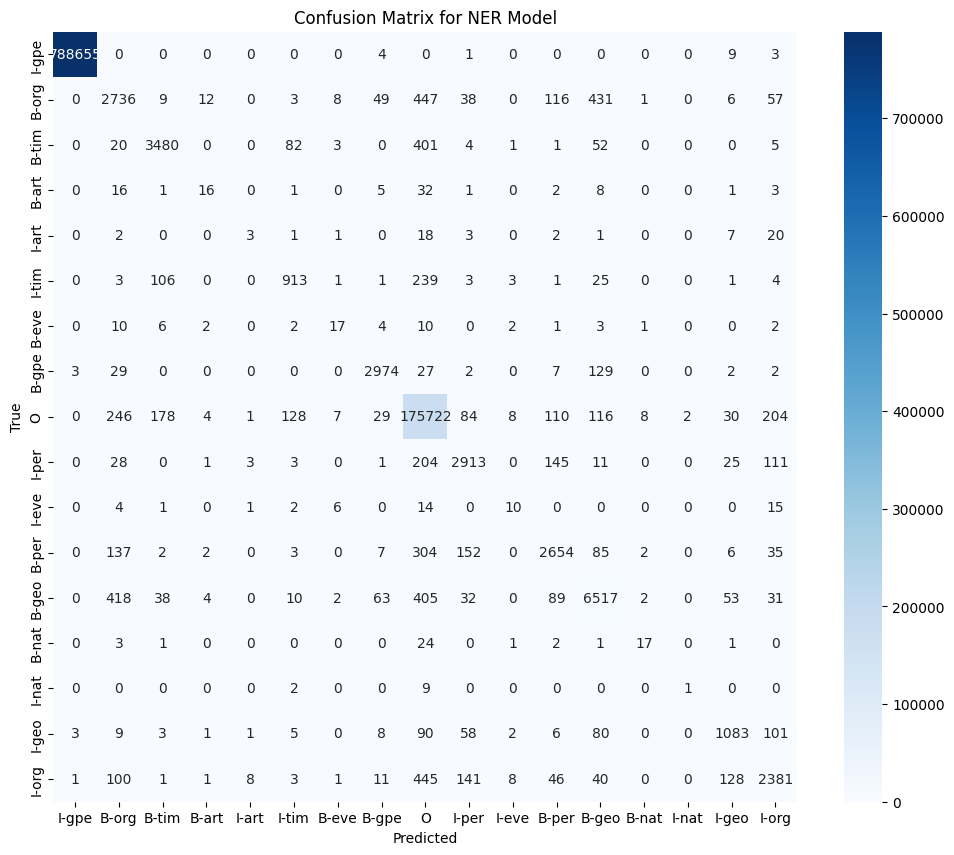

In [28]:
# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=tags)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tags, yticklabels=tags)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for NER Model")
plt.show()
